In [1]:
import sys
from time import time
from scipy import stats, sparse
from scipy.sparse.linalg import svds, eigs
from scipy.special import expit
import numpy as np
import os
import math
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from sklearn.metrics import precision_recall_curve
from sklearn import metrics
import collections
import scipy
from scipy.stats import norm as dist_model
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.cross_decomposition import CCA
import pandas as pd
import matplotlib.ticker as mtick
from matplotlib.colors import ListedColormap
from collections import defaultdict
import seaborn as sns
from scipy.stats import gaussian_kde
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
import pickle as pkl

#from utils import *
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

#Lemur 1 = Bernard (male); Lemur 2 = Stumpy (female); Lemur 3 = Martine (female); Lemur 4 = Antoine (male)
MEDIUM_SIZE = 8
SMALLER_SIZE = 6
plt.rc('font', size=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)	 # fontsize of the axes title
plt.rc('xtick', labelsize=SMALLER_SIZE)	# fontsize of the tick labels
plt.rc('ytick', labelsize=SMALLER_SIZE)	# fontsize of the tick labels
plt.rc('figure', titlesize=MEDIUM_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('font', family='Helvetica')
plt.rc('mathtext', default='regular')

def format_ax(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
FIG_HEIGHT = 2
FIG_WIDTH = 2
dname2keyword = {'muris_facs':'Muris FACS','muris_droplet':'Muris droplet','allen':'Allen',
'microcebusAntoine':'Lemur 4','microcebusBernard':'Lemur 1','microcebusMartine':'Lemur 3','microcebusStumpy':'Lemur 2'}
dname2keyword_raw = {'muris_facs':'Muris FACS','muris_droplet':'Muris droplet','allen':'Allen',
'microcebusAntoine':'Lemur 4','microcebusBernard':'Lemur 1','microcebusMartine':'Lemur 3','microcebusStumpy':'Lemur 2'}
for dname in dname2keyword_raw:
    st = dname2keyword[dname]
    dname2keyword[dname] = ''
    for i in range(len('Muris droplet') - len(st)):
        dname2keyword[dname] += ' '
    dname2keyword[dname] += st
dnames = ['muris_facs','muris_droplet','microcebusBernard','microcebusStumpy','microcebusMartine','microcebusAntoine']

In [2]:
def ploy_scatter_heatmap(data, linked_node_list, y_name, x_name, main_node, main_node_name, prop, xlabel, fig_suffix, max_d = 330, min_d = 50, main_line_w = 1):

    prop_value = list(set(list(prop.reshape(-1))))
    prop_value.sort()
    print(prop_value)
    fig,ax = plt.subplots(1,1,figsize=(FIG_WIDTH*2 * data.shape[1] / data.shape[0] * 1.15,FIG_HEIGHT*2 * 1.1))
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    ax.set_yticks(range(len(y_name)))
    ax.set_yticklabels(y_name, fontsize = SMALLER_SIZE*1.3)
    ax.set_xticks(range(len(x_name)))
    ax.set_xticklabels(x_name, fontsize = SMALLER_SIZE*1.5)
    ax.set_xlabel(xlabel, fontsize = SMALLER_SIZE*2)
    # hide x axis and y axis
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    point_size = data.copy()
    print('Max d:', max_d)
    values = data.reshape(-1)
    values.sort()
    bb = len(values) // 5
    for i in range(4):
        print(values[(i+1) * bb], end=' ')
    print()
    bound = [5, 10, 50, 1000, 1000000]
    for i in range(len(bound)-1, -1, -1):
        add = (data <= bound[i]).sum()
        if i > 0:
            add -= (data <= bound[i-1]).sum()
        print(f' D<= {bound[i]}: {add}')
        point_size[data <= bound[i]] = (max_d - min_d) * (1 - i / (len(bound)-1)) + min_d
    main_x = []
    main_y = []
    colors = ['r', 'g', 'b']
    c_list = []
    d_list = []
    for x in range(1,  data.shape[1]):
        for y in range(data.shape[0]):
            add = 0
            for i, main_node_id in enumerate(main_node):
                if main_node_id in linked_node_list[y][x-1]:
                    main_x.append(x)
                    main_y.append(y)
                    c_list.append(colors[i])
                    d_list.append(add*3*(main_line_w + 30) + point_size[y][x])
                    add += 1

    xx = np.array([range(len(x_name)) for _ in range(len(y_name))]).reshape(-1)
    yy = np.array([[i] * len(x_name) for i in range(len(y_name))]).reshape(-1)
    ax.scatter(xx, yy, s=point_size.reshape(-1), c=prop.reshape(-1), cmap='Reds_r', alpha=0.8, edgecolors='black', linewidths=0.5)
    ax.scatter(main_x, main_y, s=d_list, c='None', edgecolors=c_list, linewidths=main_line_w)
    # for i in range(len(main_node)):
    format_ax(ax)
    # plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0), ncol=2, frameon=False, fontsize = SMALLER_SIZE*1.3)
    fig.tight_layout()
    fig.savefig(f'fig/{fig_suffix}', dpi=300)

import sys
sys.path.append('..')
import Parameters
import json
record = []
idtomeshid_path = '../forKGAttack/processed_data/GNBR/entities_reverse_dict.json'
with open(Parameters.GNBRfile+'entity_raw_name', 'rb') as fl:
    entity_raw_name = pkl.load(fl)
with open(idtomeshid_path, 'r') as fl:
    idtomeshid = json.load(fl)
with open('../DiseaseAgnostic/results/Init_0.7single.pkl', 'rb') as fl:
    a_record = pkl.load(fl)
record.append(a_record)
for i in range (1, 11, 1):
    with open(f'../DiseaseAgnostic/results/After_distmult_0.7single{i}.pkl', 'rb') as fl:
        a_record = pkl.load(fl)
    record.append(a_record)
# for i in range(len(record)):
#     print(record[i])
with open('../DiseaseAgnostic/results/name_list_0.7single.txt', 'r') as fl:
    name_list = fl.readlines()

linked_node_list = [ [] for _ in range(10)]
for link_num in range(1, 11):
    attack_path = f'../DiseaseAgnostic/processed_data/attack_edge_distmult_0.7single{link_num}.pkl'
    with open(attack_path, 'rb') as fl:
        Attack_edge_list = pkl.load(fl)
    for i, edge_list in enumerate(Attack_edge_list):
        # print(i)
        linked_nodes = []
        if link_num == 1:
            edge_list = [edge_list]
        for edge in edge_list:
            s, r, o = edge
            s_mesh = idtomeshid[str(s)]
            o_mesh = idtomeshid[str(o)]
            s_type = s_mesh.split('_')[0]
            o_type = o_mesh.split('_')[0]
            if s_type != 'chemical':
                linked_nodes.append(s_mesh)
                assert o_type == 'chemical'
            if o_type != 'chemical':
                linked_nodes.append(o_mesh)
                assert s_type == 'chemical'
        # print(len(linked_node_list))

        linked_node_list[i].append(linked_nodes)

counter = defaultdict(int)
prop = []
for i in range(10):
    all_nodes = []
    prop.append([1.])
    for nodes in linked_node_list[i]:
        all_nodes += nodes
        add = 0
        for node in nodes:
            node_type = node.split('_')[0]
            if node_type == 'disease':
                add += 1
        # print(add / len(nodes), end=' ')
        prop[-1].append(add / len(nodes))
    # print()
    all_nodes = list(set(all_nodes))
    for node in all_nodes:
        counter[node] += 1
counter_list = [(k, v) for k, v in counter.items()]
counter_list.sort(key=lambda x: x[1], reverse=True)
print(counter_list[:10])
main_node = []
main_node_name = []
for s, count in counter_list[:10]:
    if count / 10 > 0.5:
        main_node.append(s)
        main_node_name.append(entity_raw_name[s])
print('Main node:', main_node)
print('Main node name:', main_node_name)
# Upper the first

name_list = [x.strip() for x in name_list]
print(name_list)
record = np.array(record)
# record = np.log10(record)
record = record.transpose()
print(record.shape)
print(record.min(), record.max())
index = np.array(range(11))
prop = np.array(prop)    
print(prop.shape)
ploy_scatter_heatmap(record, linked_node_list, name_list, index, main_node, main_node_name, prop, 'Number of malicious links', 'Fig2g.pdf', max_d=485, min_d=40, main_line_w = 0.7)

FileNotFoundError: [Errno 2] No such file or directory: '../forKGAttack/processed_data/GNBR/entities_reverse_dict.json'

Main node name: ['Leukocytopenia', 'Agaricus catalepsy', 'Methemoglobinemias']
['CL285032', 'allylglycine', 'Azaperone', 'BSH', 'Cervisol', 'Methsuximide', 'Carglumic Acid', 'Lithium citrate', 'Astemizol', 'N-tritylmorpholine']
Max d: 580
 D<= 1000000: 10
 D<= 1000: 17
 D<= 50: 23
 D<= 10: 27
 D<= 5: 33
(110,) (110,)


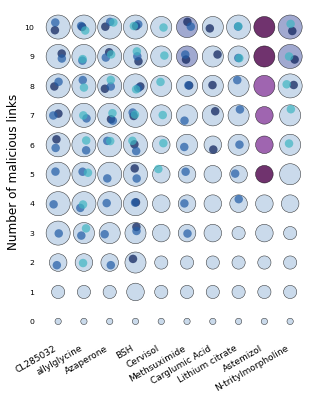

In [11]:
def ploy_scatter_heatmap(data, linked_node_list, y_name, x_name, main_node, main_node_name, prop, xlabel, fig_suffix, max_d = 330, min_d = 50, main_line_w = 1):

    # each point is a circle, the diameter of the circle is proportional to the data, the color is proportional to the prop
    # data: 2d array, each row is a data point
    # y_name: 1d array, the name of each row
    # x_name: 1d array, the name of each column
    # main_node: 1d array, the id of mani_node
    # main_node_name: 1d array, the name of main_node
    # prop: 2d array, the prop of each data point
    # xlabel: string, the label of x axis
    # fig_suffix: string, the suffix of the figure name

    fig,ax = plt.subplots(1,1,figsize=(FIG_WIDTH*2 * data.shape[1] / data.shape[0] * 1,FIG_HEIGHT*2 * 1.4))
    # ax.xaxis.set_label_position('top')
    ax.set_yticks(range(len(x_name)))
    ax.set_yticklabels(x_name, fontsize = SMALLER_SIZE*1.3)
    ax.set_xticks(range(len(y_name)))
    ax.set_xticklabels(y_name, fontsize = SMALLER_SIZE*1.5, rotation=30, ha='right')
    ax.set_ylabel(xlabel, fontsize = SMALLER_SIZE*2)
    # hide x axis and y axis
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    point_size = data.copy()
    print('Max d:', max_d)
    values = data.reshape(-1)
    values.sort()
    bound = [5, 10, 50, 1000, 1000000]

    for i in range(len(bound)-1, -1, -1):
        add = (data <= bound[i]).sum()
        if i > 0:
            add -= (data <= bound[i-1]).sum()
        print(f' D<= {bound[i]}: {add}')
        point_size[data <= bound[i]] = (max_d - min_d) * (1 - i / (len(bound)-1)) + min_d
    
    facecolors = ['#470068', '#ae007d', '#f566a1', '#fac5bf']
    facecolors = ['#071c57', '#215ca6', '#3fb5c2', '#c7e8b3']
    facecolors = ['#4c004a', '#873f9c', '#8a94c5', '#bdd1e6']
    prop_bound = [0.8, 0.88, 0.9, 1.0]
    prop_color = prop.copy().astype(str)
    for i in range(len(prop_bound)-1, -1, -1):
        prop_color[prop <= prop_bound[i]] = facecolors[i]
    prop_color = prop_color.reshape(-1)

    xx = np.array([range(len(x_name)) for _ in range(len(y_name))]).reshape(-1)
    yy = np.array([[i] * len(x_name) for i in range(len(y_name))]).reshape(-1)
    print(xx.shape, yy.shape)
    ax.scatter(yy  ,xx, s=point_size.reshape(-1), c=prop_color, alpha=0.8, edgecolors='black', linewidths=0.5)
    main_x = []
    main_y = []
    colors = ['#c7eae5', '#80cdc1', '#35978f', '#01665e', '#8c510a', '#bf812d', '#dfc27d', '#a6cee3']
    colors = ['#4c004a', '#873f9c', '#8a94c5', '#bdd1e6'] 
    colors = ['#071c57', '#215ca6', '#3fb5c2', '#c7e8b3']
    c_list = []
    d_list = []
    np.random.seed(1)
    for x in range(1,  data.shape[1]):
        for y in range(data.shape[0]):
            add = 0
            for i, main_node_id in enumerate(main_node):
                if main_node_id in linked_node_list[y][x-1]:
                    dismin = 0.02
                    dismax = 0.22
                    dis = np.random.rand() * (dismax - dismin) + dismin
                    dx = np.random.randn()
                    dy = np.random.randn()
                    length = np.sqrt(dx**2 + dy**2)
                    dx /= length
                    dy /= length
                    main_x.append(x + dx * dis)
                    main_y.append(y + dy * dis)
                    c_list.append(colors[i])
                    # d_list.append(add*3*(main_line_w + 30) + point_size[y][x])
                    d_list.append(max_d // 8)
                    add += 1
    # ax.scatter(main_y, main_x, s=d_list, c='None', edgecolors=c_list, linewidths=main_line_w)
    ax.scatter(main_y, main_x, s=d_list, c=c_list, edgecolors='None', alpha=0.7)
    # for i in range(len(main_node)):
    format_ax(ax)
    # plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0), ncol=2, frameon=False, fontsize = SMALLER_SIZE*1.3)
    fig.tight_layout()
    fig.savefig(f'fig/{fig_suffix}', dpi=300)

import sys
sys.path.append('..')
import Parameters
import json
record = []
idtomeshid_path = '../DiseaseSpecific/processed_data/GNBR/entities_reverse_dict.json'
with open(Parameters.GNBRfile+'entity_raw_name', 'rb') as fl:
    entity_raw_name = pkl.load(fl)
with open(idtomeshid_path, 'r') as fl:
    idtomeshid = json.load(fl)
with open('../DiseaseAgnostic/results/Init_0.7single.pkl', 'rb') as fl:
    a_record = pkl.load(fl)
record.append(a_record)
for i in range (1, 11, 1):
    with open(f'../DiseaseAgnostic/results/After_distmult_0.7single{i}.pkl', 'rb') as fl:
        a_record = pkl.load(fl)
    record.append(a_record)
# for i in range(len(record)):
#     print(record[i])
with open('../DiseaseAgnostic/results/name_list_0.7single.txt', 'r') as fl:
    name_list = fl.readlines()

linked_node_list = [ [] for _ in range(10)]
for link_num in range(1, 11):
    attack_path = f'../DiseaseAgnostic/processed_data/attack_edge_distmult_0.7single{link_num}.pkl'
    with open(attack_path, 'rb') as fl:
        Attack_edge_list = pkl.load(fl)
    for i, edge_list in enumerate(Attack_edge_list):
        # print(i)
        linked_nodes = []
        if link_num == 1:
            edge_list = [edge_list]
        for edge in edge_list:
            s, r, o = edge
            s_mesh = idtomeshid[str(s)]
            o_mesh = idtomeshid[str(o)]
            s_type = s_mesh.split('_')[0]
            o_type = o_mesh.split('_')[0]
            if s_type != 'chemical':
                linked_nodes.append(s_mesh)
                assert o_type == 'chemical'
            if o_type != 'chemical':
                linked_nodes.append(o_mesh)
                assert s_type == 'chemical'
        # print(len(linked_node_list))

        linked_node_list[i].append(linked_nodes)

counter = defaultdict(int)
prop = []
for i in range(10):
    all_nodes = []
    prop.append([1.])
    for nodes in linked_node_list[i]:
        all_nodes += nodes
        add = 0
        for node in nodes:
            node_type = node.split('_')[0]
            if node_type == 'disease':
                add += 1
        prop[-1].append(add / len(nodes))
    all_nodes = list(set(all_nodes))
    for node in all_nodes:
        counter[node] += 1
counter_list = [(k, v) for k, v in counter.items()]
counter_list.sort(key=lambda x: x[1], reverse=True)
main_node = []
main_node_name = []
for s, count in counter_list[:10]:
    if count / 10 > 0.5:
        main_node.append(s)
        main_node_name.append(entity_raw_name[s])
# print('Main node:', main_node)
print('Main node name:', main_node_name)
# Upper the first
name_list = [x.strip() for x in name_list]
print(name_list)
record = np.array(record)
# record = np.log10(record)
record = record.transpose()
index = np.array(range(11))
prop = np.array(prop)    
# record = record.transpose()
# prop = prop.transpose()
ploy_scatter_heatmap(record, linked_node_list, name_list, index, main_node, main_node_name, prop, 'Number of malicious links', 'Fig2 g.pdf', max_d=580, min_d=40, main_line_w = 0.7)